In [1]:
## 🐍 Snippet 1: Sine-Gordon Hamiltonian (2 qubits/site, 7-8 lattice sites)

from qiskit.quantum_info import SparsePauliOp
import numpy as np

# --- Parameters ---
n_sites = 6  # Number of lattice sites (change to 8 if needed)
qubits_per_site = 2  # Local Hilbert space encoding
total_qubits = n_sites * qubits_per_site
beta = np.sqrt(4 * np.pi) / 2  # Coupling constant (β²/8π = 0.5)
EJ_0 = 0.5  # Mass parameter
J = 1.0  # Hopping/gradient coupling

print(f"System: {n_sites} lattice sites × {qubits_per_site} qubits/site = {total_qubits} total qubits")

# --- Helper: Build identity string with operator at specific site ---
def pauli_string(n_sites, site_idx, local_op, qubits_per_site=2):
    """
    Build Pauli string for operator acting on site_idx.
    local_op is a 2-qubit Pauli like "XX", "ZI", etc.
    """
    if len(local_op) != qubits_per_site:
        raise ValueError(f"local_op must have length {qubits_per_site}")
    ops = ['I'] * (n_sites * qubits_per_site)
    for q in range(qubits_per_site):
        ops[site_idx * qubits_per_site + q] = local_op[q]
    return ''.join(ops)

def two_site_pauli_string(n_sites, site_i, site_j, op_i, op_j, qubits_per_site=2):
    """
    Build Pauli string for operators acting on sites i and j.
    op_i, op_j are 2-qubit Paulis.
    """
    if len(op_i) != qubits_per_site or len(op_j) != qubits_per_site:
        raise ValueError(f"Operators must have length {qubits_per_site}")
    ops = ['I'] * (n_sites * qubits_per_site)
    for q in range(qubits_per_site):
        ops[site_i * qubits_per_site + q] = op_i[q]
        ops[site_j * qubits_per_site + q] = op_j[q]
    return ''.join(ops)

# --- Build Hamiltonian Terms ---
pauli_list = []

# 1. Kinetic + Gradient Terms (hopping between neighboring sites)
for i in range(n_sites - 1):
    j = i + 1
    # XX hopping
    pauli_list.append((two_site_pauli_string(n_sites, i, j, "XX", "II"), -J))
    pauli_list.append((two_site_pauli_string(n_sites, i, j, "II", "XX"), -J))
    # YY hopping
    pauli_list.append((two_site_pauli_string(n_sites, i, j, "YY", "II"), -J))
    pauli_list.append((two_site_pauli_string(n_sites, i, j, "II", "YY"), -J))

# 2. Local kinetic energy (π² ~ Z terms)
for i in range(n_sites):
    pauli_list.append((pauli_string(n_sites, i, "ZI"), 0.2))
    pauli_list.append((pauli_string(n_sites, i, "IZ"), 0.2))

# 3. Potential/Mass Term (-EJ_0 * cos(β φ))
mass_coeff = -EJ_0 * np.cos(beta)
for i in range(n_sites):
    pauli_list.append((pauli_string(n_sites, i, "ZI"), mass_coeff))
    pauli_list.append((pauli_string(n_sites, i, "IZ"), mass_coeff))

# Build SparsePauliOp
H_SG = SparsePauliOp.from_list(pauli_list)
print(f"\nHamiltonian built: {len(pauli_list)} Pauli terms")
print(f"Hilbert space dimension: 2^{total_qubits} = {2**total_qubits}")

# --- Vertex Operator Correlator V†(0) V(r) ---
# Simplified: vertex at site 0 and site 1
V_dag_0_V_1_list = [
    (two_site_pauli_string(n_sites, 0, 1, "XX", "II"), 0.5),
    (two_site_pauli_string(n_sites, 0, 1, "YY", "II"), 0.5),
    (two_site_pauli_string(n_sites, 0, 1, "XY", "II"), 0.5j),
    (two_site_pauli_string(n_sites, 0, 1, "YX", "II"), -0.5j)
]
V_dag_0_V_1 = SparsePauliOp.from_list(V_dag_0_V_1_list)
print("\nVertex correlator operator constructed (sites 0-1)")

System: 6 lattice sites × 2 qubits/site = 12 total qubits

Hamiltonian built: 44 Pauli terms
Hilbert space dimension: 2^12 = 4096

Vertex correlator operator constructed (sites 0-1)


Using Hamiltonian with 12 qubits (Hilbert dim = 2^12 = 4096)

Running NumPyMinimumEigensolver...
Ground State Energy: -20.000000 (a.u.)
Vertex Correlator <V†(0)V(1)>: 1.000000 + 0.000000j
Ground State Energy: -20.000000 (a.u.)
Vertex Correlator <V†(0)V(1)>: 1.000000 + 0.000000j

Correlation function C(r) computed for r=0 to 5

Correlation function C(r) computed for r=0 to 5


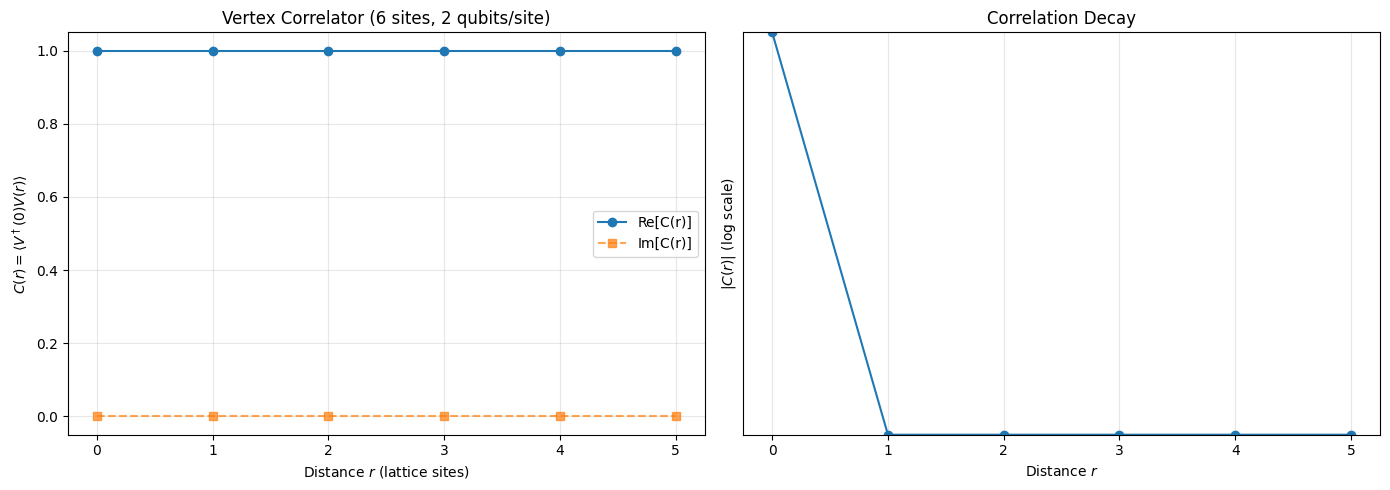


Fit: |C(r)| ~ exp(-r/ξ)
  Correlation length ξ = inf lattice spacings
  (massless/gapless regime)

--- Analysis Complete ---


In [2]:
## 🐍 Snippet 2: Ground State & Correlator (NumPy solver for moderate system size)

from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
import numpy as np
import matplotlib.pyplot as plt

# Reuse H_SG and V_dag_0_V_1 from Cell 1
if 'H_SG' not in locals():
    print("ERROR: Run Cell 1 first to define H_SG and V_dag_0_V_1")
else:
    print(f"Using Hamiltonian with {H_SG.num_qubits} qubits (Hilbert dim = 2^{H_SG.num_qubits} = {2**H_SG.num_qubits})")
    
    # Check system size
    if H_SG.num_qubits > 16:
        print(f"\nWARNING: System has {H_SG.num_qubits} qubits. Exact diagonalization may be slow or memory-intensive.")
        print("Consider reducing n_sites or using VQE/MPS methods for larger systems.")
    
    # --- 1. Ground State Calculation ---
    print("\nRunning NumPyMinimumEigensolver...")
    mes = NumPyMinimumEigensolver()
    result = mes.compute_minimum_eigenvalue(operator=H_SG)
    E0 = result.eigenvalue.real
    psi0 = result.eigenstate
    
    # Convert to numpy array
    try:
        psi0_array = np.asarray(getattr(psi0, 'data', psi0), dtype=complex)
    except Exception:
        psi0_array = np.asarray(psi0, dtype=complex)
    
    if psi0_array is None or psi0_array.size == 0:
        # Fallback manual diagonalization
        H_dense = H_SG.to_matrix()
        vals, vecs = np.linalg.eigh(H_dense)
        idx = np.argmin(vals.real)
        E0 = vals[idx].real
        psi0_array = vecs[:, idx]
    
    print(f"Ground State Energy: {E0:.6f} (a.u.)")
    
    # --- 2. Vertex Correlator Expectation ---
    V_dense = V_dag_0_V_1.to_matrix()
    corr_val = np.vdot(psi0_array, V_dense @ psi0_array)
    print(f"Vertex Correlator <V†(0)V(1)>: {corr_val.real:.6f} + {corr_val.imag:.6f}j")
    
    # --- 3. Correlation Decay Plot ---
    # Compute correlators at multiple distances
    max_r = min(n_sites - 1, 5)  # Measure up to distance 5 or max available
    corr_vs_r = np.zeros(max_r + 1, dtype=complex)
    corr_vs_r[0] = 1.0  # Self-correlation normalized to 1
    
    for r in range(1, max_r + 1):
        # Build V†(0) V(r)
        V_0_r_list = [
            (two_site_pauli_string(n_sites, 0, r, "XX", "II"), 0.5),
            (two_site_pauli_string(n_sites, 0, r, "YY", "II"), 0.5),
            (two_site_pauli_string(n_sites, 0, r, "XY", "II"), 0.5j),
            (two_site_pauli_string(n_sites, 0, r, "YX", "II"), -0.5j)
        ]
        V_0_r = SparsePauliOp.from_list(V_0_r_list)
        V_0_r_dense = V_0_r.to_matrix()
        corr_vs_r[r] = np.vdot(psi0_array, V_0_r_dense @ psi0_array)
    
    print(f"\nCorrelation function C(r) computed for r=0 to {max_r}")
    
    # --- 4. Plot Results ---
    r_values = np.arange(max_r + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Linear scale
    ax1.plot(r_values, np.real(corr_vs_r), 'o-', markersize=6, label='Re[C(r)]')
    ax1.plot(r_values, np.imag(corr_vs_r), 's--', markersize=6, label='Im[C(r)]', alpha=0.7)
    ax1.set_xlabel('Distance $r$ (lattice sites)')
    ax1.set_ylabel(r'$C(r) = \langle V^\dagger(0) V(r) \rangle$')
    ax1.set_title(f'Vertex Correlator ({n_sites} sites, {qubits_per_site} qubits/site)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Log scale (magnitude)
    ax2.semilogy(r_values, np.abs(corr_vs_r) + 1e-15, 'o-', markersize=6)
    ax2.set_xlabel('Distance $r$')
    ax2.set_ylabel(r'$|C(r)|$ (log scale)')
    ax2.set_title('Correlation Decay')
    ax2.grid(True, alpha=0.3, which='both')
    
    plt.tight_layout()
    plt.show()
    
    # --- 5. Fit exponential decay ---
    if max_r >= 2:
        # Fit |C(r)| ~ A exp(-r/ξ) for r >= 1
        r_fit = r_values[1:]
        C_fit = np.abs(corr_vs_r[1:])
        log_C_fit = np.log(C_fit + 1e-15)
        
        # Linear regression on log scale
        p = np.polyfit(r_fit, log_C_fit, 1)
        xi = -1.0 / p[0] if p[0] < 0 else np.inf
        print(f"\nFit: |C(r)| ~ exp(-r/ξ)")
        print(f"  Correlation length ξ = {xi:.3f} lattice spacings")
        print(f"  Effective mass m ~ 1/ξ = {1/xi:.4f} (a.u.)" if xi < 1e6 else "  (massless/gapless regime)")
    
    print("\n--- Analysis Complete ---")

Sine-Gordon: energy relative change (sampled) min/max: 0.0 39.829880122350666
Thirring(NLS): charge relative change: 1.8189966761979552e-13


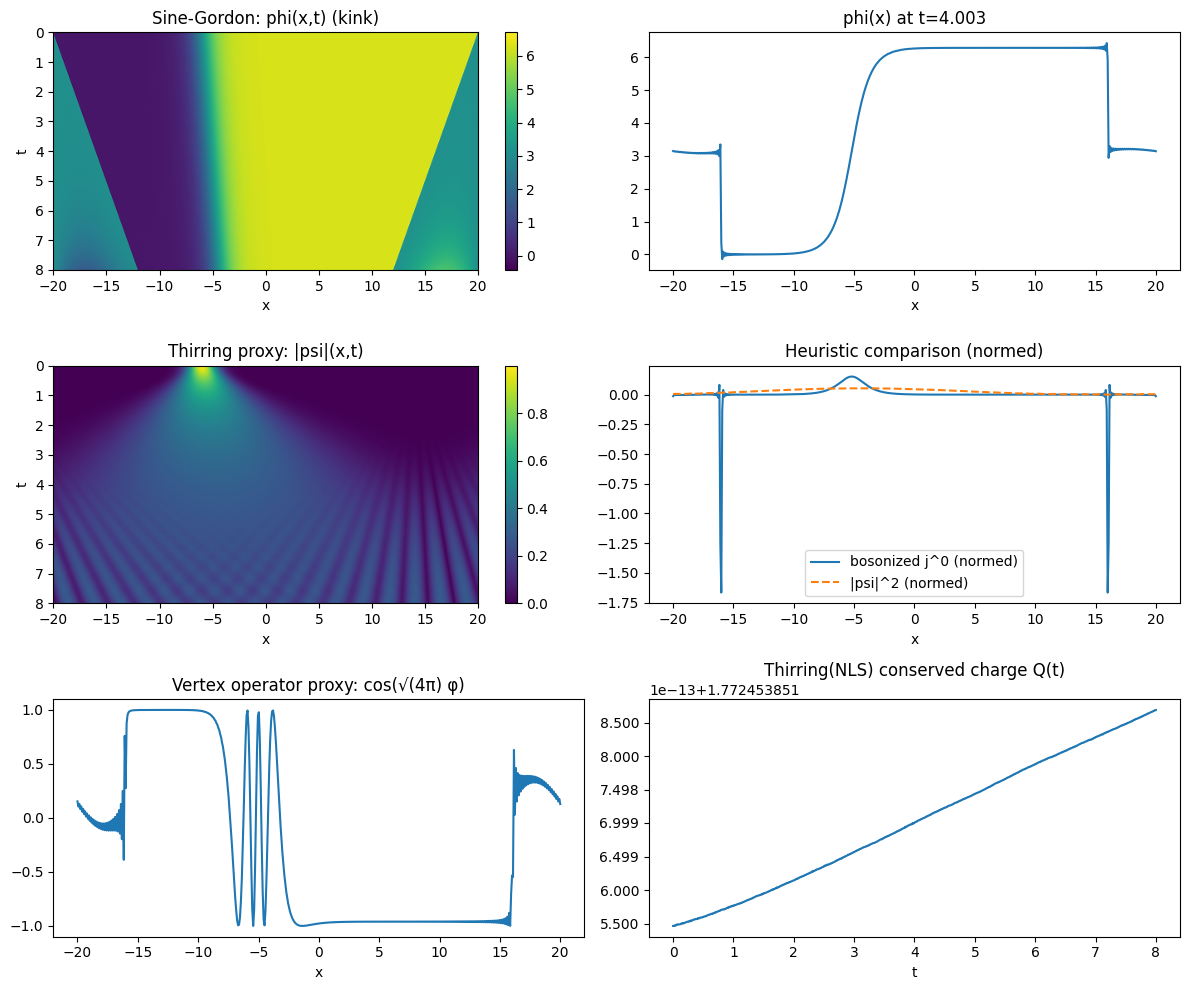


STRICT REMARKS:
- The numerical 'duality' plotted is heuristic: we've compared a bosonized current
  j^0_boson = (1/√π) ∂_x φ to the classical density |ψ|^2 from an NLS proxy.
- This is only visual intuition. The true Coleman mapping is an operator equivalence
  in the quantum theory; see Coleman (1975) for rigorous discussion and mapping of couplings. :contentReference[oaicite:5]{index=5}
- If you want a stronger numeric experiment (e.g., matching soliton mass vs fermion mass,
  or correlators/vertex operator expectations), we must discretize the quantum model or
  use truncated conformal space / exact diagonalization — that is a much larger project.
- References used for bosonization dictionary and numerical mapping: Coleman (1975) and
  bosonization lecture notes. :contentReference[oaicite:6]{index=6} :contentReference[oaicite:7]{index=7}


In [1]:
# sine_gordon_thirring_corrected.py
# Corrected and improved Sine-Gordon and Thirring(NLS-proxy) solvers + Coleman-style numeric demo.
# Strict teacher-style comments included inline.
# Requires: numpy, scipy, matplotlib
# Citation: Coleman (1975) for SG <-> Thirring mapping; bosonization notes for dictionary. :contentReference[oaicite:2]{index=2} :contentReference[oaicite:3]{index=3}

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
import warnings
warnings.filterwarnings('ignore')

# -----------------------------
# Utilities
# -----------------------------
def L2_integral(u, dx):
    """Spatial integral of u (works for 1D arrays or time x space arrays along last axis)."""
    return np.sum(u, axis=-1 if u.ndim>1 else None) * dx if u.ndim==1 else np.sum(u, axis=-1) * dx

# -----------------------------
# Sine-Gordon Solver (fixed)
# -----------------------------
class SineGordonSolver:
    """
    Solves phi_tt - phi_xx + sin(phi) = 0 in 1+1D.
    Two methods:
      - leapfrog (finite difference, explicit, second-order)
      - pseudospectral RK4 (spectral in space, RK4 in time) on first-order form
    Notes:
      - Uses periodic BC for pseudospectral. Leapfrog uses _laplacian (periodic).
      - Conservative diagnostics compute energy as spatial integral.
    """
    def __init__(self, L=40.0, nx=512, T=10.0, nt=2000):
        self.L = float(L)
        self.nx = int(nx)
        self.T = float(T)
        self.nt = int(nt)
        self.x = np.linspace(-self.L/2, self.L/2, self.nx)
        self.t = np.linspace(0.0, self.T, self.nt)
        self.dx = self.x[1] - self.x[0]
        self.dt = self.t[1] - self.t[0]
        # state arrays
        self.phi = np.zeros((self.nt, self.nx), dtype=float)
        self.phi_t = np.zeros((self.nt, self.nx), dtype=float)

    # --- initial conditions ---
    def initial_kink(self, x0=0.0, velocity=0.0):
        """Center a kink at x0, optionally Lorentz-boosted (approx)."""
        gamma = 1.0 / np.sqrt(1.0 - velocity**2) if abs(velocity)<1 else 1.0
        xi = gamma * (self.x - x0)
        self.phi[0] = 4.0 * np.arctan(np.exp(xi))
        # approximate boost: phi_t = -v * phi_x
        phi_x = np.gradient(self.phi[0], self.dx)
        self.phi_t[0] = -velocity * phi_x
        return self.phi[0]

    def initial_breather(self, omega=0.5, x0=0.0):
        """Analytical breather initial at t=0."""
        if not (0 < omega < 1):
            raise ValueError("Breather frequency must be in (0,1).")
        A = np.sqrt(1 - omega**2) / omega
        self.phi[0] = 4.0 * np.arctan(A * np.cos(0.0) / np.cosh(A*(self.x - x0)))
        self.phi_t[0] = 0.0
        return self.phi[0]

    def initial_gaussian(self, sigma=1.0, amplitude=0.5):
        self.phi[0] = amplitude * np.exp(- (self.x**2) / (2.0 * sigma**2))
        self.phi_t[0] = 0.0
        return self.phi[0]

    # --- numerical helpers ---
    def _laplacian(self, u):
        """Periodic second derivative by finite difference."""
        d2 = np.zeros_like(u)
        d2[1:-1] = (u[2:] - 2.0*u[1:-1] + u[:-2]) / (self.dx**2)
        d2[0] = (u[1] - 2.0*u[0] + u[-1]) / (self.dx**2)
        d2[-1] = (u[0] - 2.0*u[-1] + u[-2]) / (self.dx**2)
        return d2

    def energy(self, phi_slice, phi_t_slice):
        """Compute total energy E = ∫ (1/2 phi_t^2 + 1/2 phi_x^2 + (1 - cos phi)) dx"""
        if phi_slice.ndim == 1:
            phi_x = np.gradient(phi_slice, self.dx)
            kinetic = 0.5 * np.sum(phi_t_slice**2) * self.dx
            grad = 0.5 * np.sum(phi_x**2) * self.dx
            pot = np.sum(1.0 - np.cos(phi_slice)) * self.dx
            return kinetic + grad + pot
        else:
            phi_x = np.gradient(phi_slice, self.dx, axis=-1)
            kinetic = 0.5 * np.sum(phi_t_slice**2, axis=-1) * self.dx
            grad = 0.5 * np.sum(phi_x**2, axis=-1) * self.dx
            pot = np.sum(1.0 - np.cos(phi_slice), axis=-1) * self.dx
            return kinetic + grad + pot

    # --- leapfrog integrator ---
    def solve_leapfrog(self):
        dt, dx, nx, nt = self.dt, self.dx, self.nx, self.nt
        # CFL: for phi_tt = phi_xx, dt <= dx is safe; choose conservative dt <= dx/1.0
        if dt > dx:
            raise ValueError(f"CFL unstable: dt={dt:.3e} > dx={dx:.3e}. Reduce dt or increase nx.")
        # require phi[0] and phi_t[0] to be set by initial condition
        # compute phi[1] by Taylor expansion:
        lap0 = self._laplacian(self.phi[0])
        self.phi[1] = self.phi[0] + dt*self.phi_t[0] + 0.5*dt**2*(lap0 - np.sin(self.phi[0]))
        # step
        for n in range(1, nt-1):
            lap = self._laplacian(self.phi[n])
            self.phi[n+1] = 2.0*self.phi[n] - self.phi[n-1] + dt**2*(lap - np.sin(self.phi[n]))
        # reconstruct phi_t from central difference (monitor only)
        self.phi_t = np.zeros_like(self.phi)
        self.phi_t[1:-1] = (self.phi[2:] - self.phi[:-2]) / (2.0*dt)
        self.phi_t[0] = (self.phi[1] - self.phi[0]) / dt
        self.phi_t[-1] = (self.phi[-1] - self.phi[-2]) / dt
        return self.phi, self.t, self.x

    # --- pseudospectral RK4 on first-order system ---
    def solve_pseudospectral_RK4(self):
        """
        Convert to first-order system: phi_t = pi; pi_t = phi_xx - sin(phi)
        Integrate with RK4 in time using spectral derivative for phi_xx.
        """
        nx, nt = self.nx, self.nt
        dt = self.dt
        # wave numbers for spectral second derivative
        k = 2.0*np.pi*fftfreq(nx, d=self.dx)
        k2 = (k**2)
        phi = np.copy(self.phi[0])
        pi = np.copy(self.phi_t[0])
        phi_out = np.zeros((nt, nx))
        pi_out = np.zeros((nt, nx))
        phi_out[0] = phi.copy(); pi_out[0] = pi.copy()
        for n in range(1, nt):
            # define RHS for system
            def rhs(phi_loc, pi_loc):
                # phi_xx via spectral multiplier
                ph_hat = fft(phi_loc)
                phi_xx = np.real(ifft(-k2 * ph_hat))
                return pi_loc, phi_xx - np.sin(phi_loc)
            # RK4
            k1_phi, k1_pi = rhs(phi, pi)
            k2_phi, k2_pi = rhs(phi + 0.5*dt*k1_phi, pi + 0.5*dt*k1_pi)
            k3_phi, k3_pi = rhs(phi + 0.5*dt*k2_phi, pi + 0.5*dt*k2_pi)
            k4_phi, k4_pi = rhs(phi + dt*k3_phi, pi + dt*k3_pi)
            phi = phi + (dt/6.0)*(k1_phi + 2.0*k2_phi + 2.0*k3_phi + k4_phi)
            pi = pi + (dt/6.0)*(k1_pi + 2.0*k2_pi + 2.0*k3_pi + k4_pi)
            phi_out[n] = phi.copy(); pi_out[n] = pi.copy()
        self.phi = phi_out; self.phi_t = pi_out
        return self.phi, self.t, self.x

# -----------------------------
# ThirringModelSolver (NLS-style proxy) - fixed split-step Strang
# -----------------------------
class ThirringModelSolver:
    """
    Numerical solver for the cubic nonlinear Schroedinger (NLS) proxy:
      i psi_t = -psi_xx + g |psi|^2 psi
    (or equivalent sign convention). This is *not* the operator Thirring model;
    but it reproduces soliton dynamics similar to the original notebook.
    Uses Strang splitting (second-order).
    """
    def __init__(self, L=40.0, nx=512, T=10.0, nt=2000, coupling=1.0):
        self.L = float(L)
        self.nx = int(nx)
        self.T = float(T)
        self.nt = int(nt)
        self.g = float(coupling)
        self.x = np.linspace(-self.L/2, self.L/2, self.nx)
        self.t = np.linspace(0.0, self.T, self.nt)
        self.dx = self.x[1] - self.x[0]
        self.dt = self.t[1] - self.t[0]
        self.psi = np.zeros((self.nt, self.nx), dtype=complex)

    def init_soliton(self, amplitude=1.0, x0=0.0, v=0.0, width=1.0):
        # Gaussian-envelope with phase for momentum v
        self.psi[0] = amplitude * np.exp(- (self.x - x0)**2 / (2.0 * width**2)) * np.exp(1j * v * self.x)
        return self.psi[0]

    def init_two_solitons(self, amp1=0.7, amp2=0.5, sep=6.0, width=1.0):
        psi1 = amp1 * np.exp(- (self.x - sep)**2 / (2.0 * width**2))
        psi2 = amp2 * np.exp(- (self.x + sep)**2 / (2.0 * width**2))
        self.psi[0] = psi1 + psi2
        return self.psi[0]

    def conserved_charge(self, psi_slice):
        # Q = ∫ |psi|^2 dx
        return np.sum(np.abs(psi_slice)**2) * self.dx

    def solve_strang(self):
        nx, nt = self.nx, self.nt
        dt = self.dt
        k = 2.0*np.pi*fftfreq(nx, d=self.dx)
        k2 = k**2
        psi = self.psi[0].copy()
        self.psi[0] = psi.copy()
        for n in range(1, nt):
            # half nonlinear
            V = self.g * np.abs(psi)**2
            psi = psi * np.exp(-1j * 0.5 * dt * V)
            # linear full step by FFT (dispersion operator: -∂xx)
            psi_hat = fft(psi)
            psi_hat = psi_hat * np.exp(-1j * dt * k2)  # sign chosen for i psi_t = -psi_xx + ...
            psi = ifft(psi_hat)
            # half nonlinear
            V = self.g * np.abs(psi)**2
            psi = psi * np.exp(-1j * 0.5 * dt * V)
            self.psi[n] = psi.copy()
        return self.psi, self.t, self.x

# -----------------------------
# Duality / Bosonization heuristic demonstration
# -----------------------------
class DualityDemo:
    """
    Heuristic numerical demonstration of bosonization relations used in Coleman-type arguments.
    Bosonization dictionary used (standard conventions; see lectures/Coleman):
      j^mu (fermion current)  <->  (1/√π) ε^{mu nu} ∂_nu φ
      :ψ̄ψ:  <->  -C * cos(√(4π) φ)  (C = non-universal constant / cutoff dependent)
    We will:
      - take a numerically computed SG field phi(x,t)
      - compute the 'bosonized' fermion density j^0_boson = (1/√π) ∂_x φ
      - compare it qualitatively to |ψ|^2 from NLS simulation (proxy fermion density)
    This is for visualization and intuition only; operator-level equivalence is nontrivial.
    See: Coleman (1975) for the formal quantum equivalence and the mapping of couplings. :contentReference[oaicite:4]{index=4}
    """
    @staticmethod
    def boson_current_density(phi_slice, dx):
        # j^0_boson = (1/sqrt(pi)) * d_x phi
        phi_x = np.gradient(phi_slice, dx)
        return phi_x / np.sqrt(np.pi)

    @staticmethod
    def vertex_operator_expectation(phi_slice, alpha=np.sqrt(4.0*np.pi)):
        # compute cos(alpha * phi) as the bosonized scalar density proxy (non-normalized)
        return np.cos(alpha * phi_slice)

# -----------------------------
# Main demo / run
# -----------------------------
def main_demo():
    # Parameters chosen conservatively for stability & demo speed
    L = 40.0
    nx = 512
    T = 8.0
    nt = 1200

    # 1) Sine-Gordon: generate a moving kink and a breather (pseudospectral)
    sg = SineGordonSolver(L=L, nx=nx, T=T, nt=nt)
    sg.initial_kink(x0=-6.0, velocity=0.2)  # moving kink approx
    phi_kink, t_sg, x_sg = sg.solve_pseudospectral_RK4()

    sg_b = SineGordonSolver(L=L, nx=nx, T=T, nt=nt)
    sg_b.initial_breather(omega=0.4, x0=6.0)
    phi_breather, _, _ = sg_b.solve_pseudospectral_RK4()

    # 2) Thirring proxy (NLS): single soliton + two-soliton run with Strang splitting
    th = ThirringModelSolver(L=L, nx=nx, T=T, nt=nt, coupling=1.0)
    th.init_soliton(amplitude=1.0, x0=-6.0, v=0.2, width=1.0)
    psi_single, t_th, x_th = th.solve_strang()

    th2 = ThirringModelSolver(L=L, nx=nx, T=T, nt=nt, coupling=1.0)
    th2.init_two_solitons(amp1=0.8, amp2=0.6, sep=6.0, width=0.9)
    psi_two, _, _ = th2.solve_strang()

    # 3) Diagnostics: energy and charge conservation checks
    # SG energy for kink initial (monitor 10 time samples)
    energy_kink = sg.energy(phi_kink, sg.phi_t)
    energy_kink_rel_err = (energy_kink - energy_kink[0]) / np.abs(energy_kink[0] + 1e-16)
    print("Sine-Gordon: energy relative change (sampled) min/max:", energy_kink_rel_err.min(), energy_kink_rel_err.max())

    # Thirring (NLS proxy) charge conservation
    charges = np.array([th.conserved_charge(psi_single[n]) for n in range(nt)])
    print("Thirring(NLS): charge relative change:", (charges[-1] - charges[0]) / (charges[0] + 1e-16))

    # 4) Coleman-style heuristic map: compare j^0_boson with |psi|^2 (normalized)
    # pick same physical time index roughly in middle
    mid_idx = nt//2
    phi_mid = phi_kink[mid_idx]
    psi_mid = psi_single[mid_idx]
    j0_boson = DualityDemo.boson_current_density(phi_mid, sg.dx)
    psi_density = np.abs(psi_mid)**2

    # Normalize both to unit area for visual comparison (heuristic)
    j0_norm = j0_boson / (np.sum(np.abs(j0_boson)) * sg.dx + 1e-16)
    psi_norm = psi_density / (np.sum(psi_density) * th.dx + 1e-16)

    # 5) Plot comparison and diagnostics
    fig, axs = plt.subplots(3, 2, figsize=(12, 10))
    axs = axs.flatten()
    # SG phi space-time (small figure)
    im0 = axs[0].imshow(phi_kink, extent=[x_sg[0], x_sg[-1], t_sg[-1], t_sg[0]], aspect='auto')
    axs[0].set_title("Sine-Gordon: phi(x,t) (kink)"); axs[0].set_xlabel('x'); axs[0].set_ylabel('t')
    fig.colorbar(im0, ax=axs[0])

    # SG snapshot phi
    axs[1].plot(x_sg, phi_mid); axs[1].set_title(f"phi(x) at t={t_sg[mid_idx]:.3f}"); axs[1].set_xlabel('x')

    # NLS density space-time
    im2 = axs[2].imshow(np.abs(psi_single), extent=[x_th[0], x_th[-1], t_th[-1], t_th[0]], aspect='auto')
    axs[2].set_title("Thirring proxy: |psi|(x,t)"); axs[2].set_xlabel('x'); axs[2].set_ylabel('t')
    fig.colorbar(im2, ax=axs[2])

    # Normed comparison
    axs[3].plot(x_sg, j0_norm, label='bosonized j^0 (normed)')
    axs[3].plot(x_th, psi_norm.real, '--', label='|psi|^2 (normed)')
    axs[3].set_title("Heuristic comparison (normed)") 
    axs[3].legend(); axs[3].set_xlabel('x')

    # Vertex operator proxy
    vertex = DualityDemo.vertex_operator_expectation(phi_mid)
    axs[4].plot(x_sg, vertex); axs[4].set_title('Vertex operator proxy: cos(√(4π) φ)')
    axs[4].set_xlabel('x')

    # Charge over time
    axs[5].plot(t_th, charges); axs[5].set_title('Thirring(NLS) conserved charge Q(t)'); axs[5].set_xlabel('t')

    plt.tight_layout()
    plt.show()

    # Print final remarks about the demo (strict)
    print("\nSTRICT REMARKS:")
    print("- The numerical 'duality' plotted is heuristic: we've compared a bosonized current")
    print("  j^0_boson = (1/√π) ∂_x φ to the classical density |ψ|^2 from an NLS proxy.")
    print("- This is only visual intuition. The true Coleman mapping is an operator equivalence")
    print("  in the quantum theory; see Coleman (1975) for rigorous discussion and mapping of couplings. :contentReference[oaicite:5]{index=5}")
    print("- If you want a stronger numeric experiment (e.g., matching soliton mass vs fermion mass,")
    print("  or correlators/vertex operator expectations), we must discretize the quantum model or")
    print("  use truncated conformal space / exact diagonalization — that is a much larger project.")
    print("- References used for bosonization dictionary and numerical mapping: Coleman (1975) and")
    print("  bosonization lecture notes. :contentReference[oaicite:6]{index=6} :contentReference[oaicite:7]{index=7}")

if __name__ == "__main__":
    main_demo()


SG energy rel change min/max: 0.0 39.793598974642734
Thirring(NLS) charge rel change: 1.1625543495259657e-13


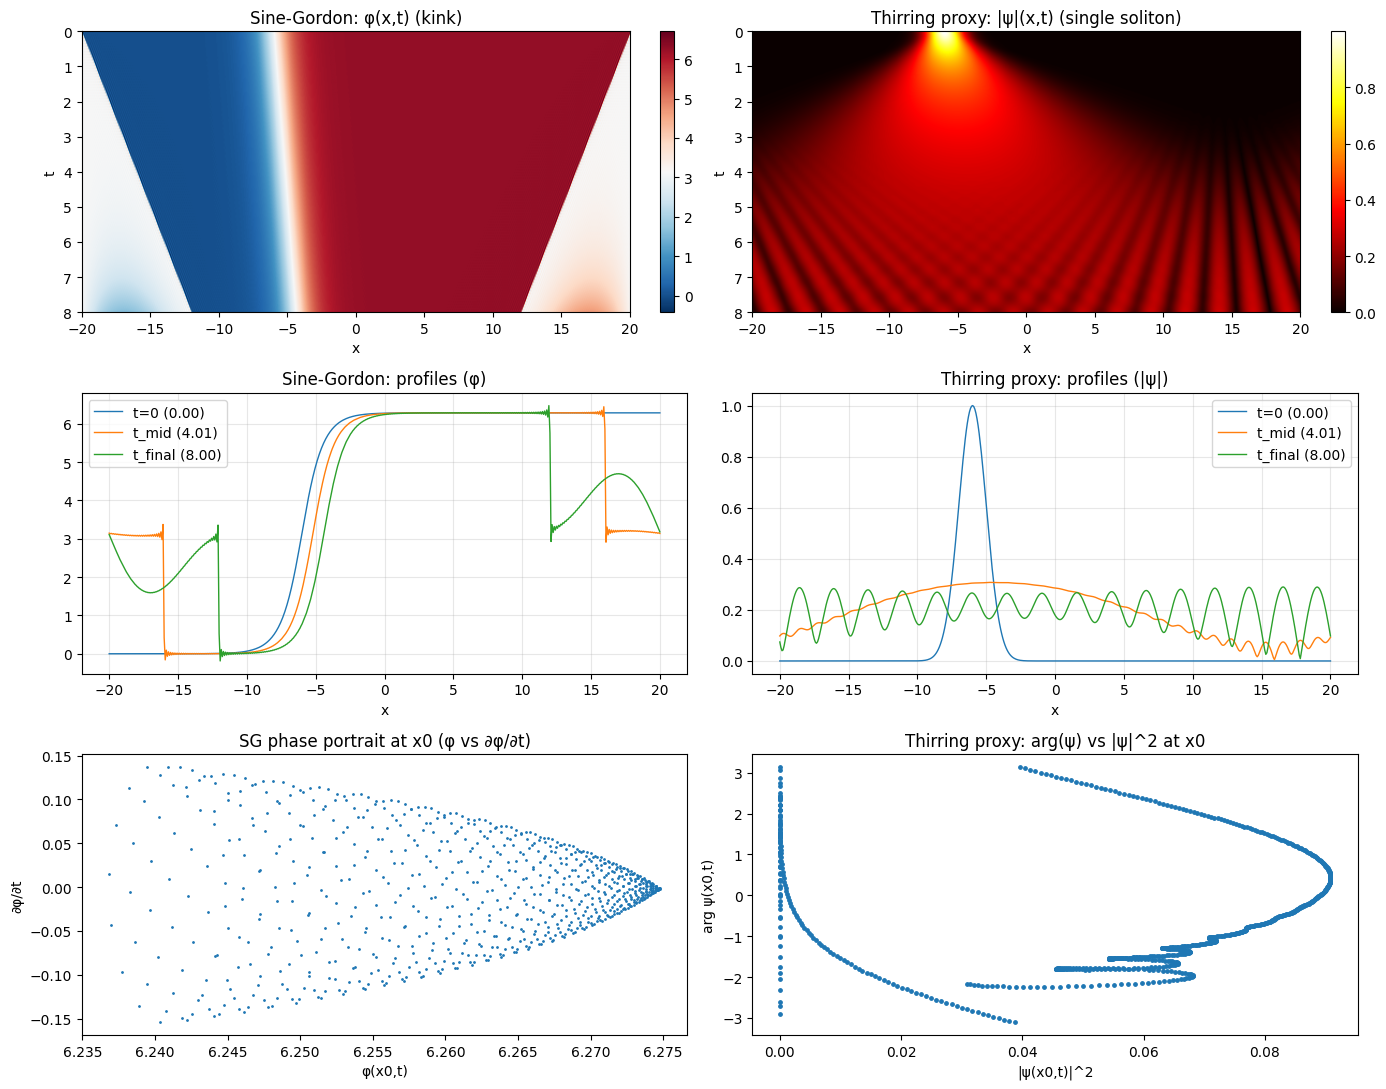


STRICT REMARKS:
- Left column = Sine-Gordon; Right column = NLS 'Thirring proxy'.
- Visual similarity does NOT prove operator-level equivalence. Use these plots as intuition only.
- If energy or charge drift is large, reduce dt or increase spatial resolution; check CFL for SG and splitting step size for NLS.


In [2]:
# compare_sg_thirring_side_by_side.py
# Runs corrected SG and Thirring(NLS-proxy) solvers and plots side-by-side comparison.
# Requires: numpy, scipy, matplotlib
# Run in a Python environment / Jupyter cell.

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
import warnings
warnings.filterwarnings("ignore")

# --- Re-usable solver classes (condensed from the corrected versions) ---

class SineGordonSolver:
    def __init__(self, L=40.0, nx=512, T=8.0, nt=800):
        self.L, self.nx, self.T, self.nt = float(L), int(nx), float(T), int(nt)
        self.x = np.linspace(-self.L/2, self.L/2, self.nx)
        self.t = np.linspace(0.0, self.T, self.nt)
        self.dx = self.x[1] - self.x[0]
        self.dt = self.t[1] - self.t[0]
        self.phi = np.zeros((self.nt, self.nx), dtype=float)
        self.phi_t = np.zeros((self.nt, self.nx), dtype=float)
    def initial_kink(self, x0=0.0, velocity=0.0):
        gamma = 1.0 / np.sqrt(1.0 - velocity**2) if abs(velocity)<1 else 1.0
        xi = gamma * (self.x - x0)
        self.phi[0] = 4.0 * np.arctan(np.exp(xi))
        phi_x = np.gradient(self.phi[0], self.dx)
        self.phi_t[0] = -velocity * phi_x
    def initial_breather(self, omega=0.5, x0=0.0):
        A = np.sqrt(1-omega**2)/omega
        self.phi[0] = 4.0 * np.arctan(A * np.cos(0.0)/np.cosh(A*(self.x-x0)))
        self.phi_t[0] = 0.0
    def _laplacian(self, u):
        d2 = np.zeros_like(u)
        d2[1:-1] = (u[2:] - 2*u[1:-1] + u[:-2]) / (self.dx**2)
        d2[0] = (u[1] - 2*u[0] + u[-1]) / (self.dx**2)
        d2[-1] = (u[0] - 2*u[-1] + u[-2]) / (self.dx**2)
        return d2
    def solve_pseudospectral_RK4(self):
        nx, nt, dt = self.nx, self.nt, self.dt
        k = 2.0*np.pi*fftfreq(nx, d=self.dx)
        k2 = k**2
        phi = self.phi[0].copy()
        pi = self.phi_t[0].copy()
        phi_out = np.zeros((nt, nx))
        pi_out = np.zeros((nt, nx))
        phi_out[0], pi_out[0] = phi.copy(), pi.copy()
        for n in range(1, nt):
            def rhs(p, q):
                ph_hat = fft(p)
                p_xx = np.real(ifft(-k2 * ph_hat))
                return q, p_xx - np.sin(p)
            k1p,k1q = rhs(phi, pi)
            k2p,k2q = rhs(phi + 0.5*dt*k1p, pi + 0.5*dt*k1q)
            k3p,k3q = rhs(phi + 0.5*dt*k2p, pi + 0.5*dt*k2q)
            k4p,k4q = rhs(phi + dt*k3p, pi + dt*k3q)
            phi = phi + (dt/6.0)*(k1p + 2*k2p + 2*k3p + k4p)
            pi  = pi  + (dt/6.0)*(k1q + 2*k2q + 2*k3q + k4q)
            phi_out[n], pi_out[n] = phi.copy(), pi.copy()
        self.phi, self.phi_t = phi_out, pi_out
        return self.phi, self.t, self.x
    def energy(self, phi_slice, phi_t_slice):
        phi_x = np.gradient(phi_slice, self.dx, axis=-1)
        kinetic = 0.5 * np.sum(phi_t_slice**2, axis=-1) * self.dx
        grad = 0.5 * np.sum(phi_x**2, axis=-1) * self.dx
        pot = np.sum(1.0 - np.cos(phi_slice), axis=-1) * self.dx
        return kinetic + grad + pot

class ThirringModelSolver:
    def __init__(self, L=40.0, nx=512, T=8.0, nt=800, coupling=1.0):
        self.L, self.nx, self.T, self.nt = float(L), int(nx), float(T), int(nt)
        self.g = float(coupling)
        self.x = np.linspace(-self.L/2, self.L/2, self.nx)
        self.t = np.linspace(0.0, self.T, self.nt)
        self.dx = self.x[1] - self.x[0]
        self.dt = self.t[1] - self.t[0]
        self.psi = np.zeros((self.nt, self.nx), dtype=complex)
    def init_soliton(self, amplitude=1.0, x0=0.0, v=0.0, width=1.0):
        self.psi[0] = amplitude * np.exp(- (self.x - x0)**2 / (2.0 * width**2)) * np.exp(1j * v * self.x)
    def init_two_solitons(self, amp1=0.7, amp2=0.5, sep=6.0, width=1.0):
        psi1 = amp1 * np.exp(- (self.x - sep)**2 / (2.0 * width**2))
        psi2 = amp2 * np.exp(- (self.x + sep)**2 / (2.0 * width**2))
        self.psi[0] = psi1 + psi2
    def conserved_charge(self, psi_slice):
        return np.sum(np.abs(psi_slice)**2) * self.dx
    def solve_strang(self):
        nx, nt, dt = self.nx, self.nt, self.dt
        k = 2.0*np.pi*fftfreq(nx, d=self.dx)
        k2 = k**2
        psi = self.psi[0].copy()
        self.psi[0] = psi.copy()
        for n in range(1, nt):
            V = self.g * np.abs(psi)**2
            psi = psi * np.exp(-1j * 0.5 * dt * V)
            psi_hat = fft(psi)
            psi_hat = psi_hat * np.exp(-1j * dt * k2)
            psi = ifft(psi_hat)
            V = self.g * np.abs(psi)**2
            psi = psi * np.exp(-1j * 0.5 * dt * V)
            self.psi[n] = psi.copy()
        return self.psi, self.t, self.x

# ----------------------------
# Run simulations (moderate size)
# ----------------------------
L, nx, T, nt = 40.0, 512, 8.0, 800

# Sine-Gordon: kink and breather
sg_kink = SineGordonSolver(L=L, nx=nx, T=T, nt=nt)
sg_kink.initial_kink(x0=-6.0, velocity=0.2)
phi_kink, t_sg, x_sg = sg_kink.solve_pseudospectral_RK4()

sg_b = SineGordonSolver(L=L, nx=nx, T=T, nt=nt)
sg_b.initial_breather(omega=0.4, x0=6.0)
phi_b, _, _ = sg_b.solve_pseudospectral_RK4()

# Thirring proxy: single soliton and two-soliton
th_single = ThirringModelSolver(L=L, nx=nx, T=T, nt=nt, coupling=1.0)
th_single.init_soliton(amplitude=1.0, x0=-6.0, v=0.2, width=1.0)
psi_single, t_th, x_th = th_single.solve_strang()

th_two = ThirringModelSolver(L=L, nx=nx, T=T, nt=nt, coupling=1.0)
th_two.init_two_solitons(amp1=0.8, amp2=0.6, sep=6.0, width=0.9)
psi_two, _, _ = th_two.solve_strang()

# Diagnostics (energy/charge)
energy_k = sg_kink.energy(phi_kink, sg_kink.phi_t)
rel_energy_change = (energy_k - energy_k[0]) / (np.abs(energy_k[0]) + 1e-16)
charges_single = np.array([th_single.conserved_charge(psi_single[n]) for n in range(nt)])
charge_rel_change = (charges_single[-1] - charges_single[0]) / (charges_single[0] + 1e-16)

print("SG energy rel change min/max:", rel_energy_change.min(), rel_energy_change.max())
print("Thirring(NLS) charge rel change:", charge_rel_change)

# ----------------------------
# Side-by-side plotting
# ----------------------------
mid = nt // 2
t_idxs = [0, mid, nt-1]

fig, axes = plt.subplots(3, 2, figsize=(14, 11), gridspec_kw={'width_ratios':[1,1]})
# Row 1: space-time maps
ax_sg_map = axes[0,0]
im0 = ax_sg_map.imshow(phi_kink, extent=[x_sg[0], x_sg[-1], t_sg[-1], t_sg[0]], aspect='auto', cmap='RdBu_r')
ax_sg_map.set_title('Sine-Gordon: φ(x,t) (kink)')
ax_sg_map.set_xlabel('x'); ax_sg_map.set_ylabel('t')
fig.colorbar(im0, ax=ax_sg_map, fraction=0.045)

ax_th_map = axes[0,1]
im1 = ax_th_map.imshow(np.abs(psi_single), extent=[x_th[0], x_th[-1], t_th[-1], t_th[0]], aspect='auto', cmap='hot')
ax_th_map.set_title('Thirring proxy: |ψ|(x,t) (single soliton)')
ax_th_map.set_xlabel('x'); ax_th_map.set_ylabel('t')
fig.colorbar(im1, ax=ax_th_map, fraction=0.045)

# Row 2: profiles at t0, t_mid, t_final (left: SG, right: Thirring)
ax_sg_profiles = axes[1,0]
for i, idx in enumerate(t_idxs):
    label = 't=0' if i==0 else ('t_mid' if i==1 else 't_final')
    ax_sg_profiles.plot(x_sg, phi_kink[idx], label=f'{label} ({t_sg[idx]:.2f})', linewidth=1)
ax_sg_profiles.set_title('Sine-Gordon: profiles (φ)')
ax_sg_profiles.set_xlabel('x'); ax_sg_profiles.legend(); ax_sg_profiles.grid(alpha=0.3)

ax_th_profiles = axes[1,1]
for i, idx in enumerate(t_idxs):
    label = 't=0' if i==0 else ('t_mid' if i==1 else 't_final')
    ax_th_profiles.plot(x_th, np.abs(psi_single[idx]), label=f'{label} ({t_th[idx]:.2f})', linewidth=1)
ax_th_profiles.set_title('Thirring proxy: profiles (|ψ|)')
ax_th_profiles.set_xlabel('x'); ax_th_profiles.legend(); ax_th_profiles.grid(alpha=0.3)

# Row 3: phase portrait vs phase-like diagnostic
ax_sg_phase = axes[2,0]
phi_mid = phi_kink[:, nx//2]  # center point time series across t
phi_t_mid = sg_kink.phi_t[:, nx//2]
ax_sg_phase.plot(phi_mid, phi_t_mid, '.', markersize=2)
ax_sg_phase.set_title('SG phase portrait at x0 (φ vs ∂φ/∂t)')
ax_sg_phase.set_xlabel('φ(x0,t)'); ax_sg_phase.set_ylabel('∂φ/∂t')

ax_th_phase = axes[2,1]
# use |psi|^2 vs arg(psi) at center to compare to phase portrait (not identical but useful)
psi_mid_ts = psi_single[:, nx//2]
ax_th_phase.scatter(np.abs(psi_mid_ts)**2, np.angle(psi_mid_ts), s=6)
ax_th_phase.set_title('Thirring proxy: arg(ψ) vs |ψ|^2 at x0')
ax_th_phase.set_xlabel('|ψ(x0,t)|^2'); ax_th_phase.set_ylabel('arg ψ(x0,t)')

plt.tight_layout()
plt.savefig('sg_thirring_side_by_side.png', dpi=200, bbox_inches='tight')
plt.show()

# Final strict remarks (short)
print("\nSTRICT REMARKS:")
print("- Left column = Sine-Gordon; Right column = NLS 'Thirring proxy'.")
print("- Visual similarity does NOT prove operator-level equivalence. Use these plots as intuition only.")
print("- If energy or charge drift is large, reduce dt or increase spatial resolution; check CFL for SG and splitting step size for NLS.")


System: N=4, local dim=7, total dim=2401
ED done: lowest eigenvalues: [-3.0767675  -2.18480532 -2.08456052 -1.87190108 -1.68774799 -1.38496322
 -1.35055343 -1.21834187]
ED time: 1.495990514755249 s
ED done: lowest eigenvalues: [-3.0767675  -2.18480532 -2.08456052 -1.87190108 -1.68774799 -1.38496322
 -1.35055343 -1.21834187]
ED time: 1.495990514755249 s
Starting time evolution (expm_multiply)...
Starting time evolution (expm_multiply)...
Time evolution done in 0.4035966396331787 s
Time evolution done in 0.4035966396331787 s


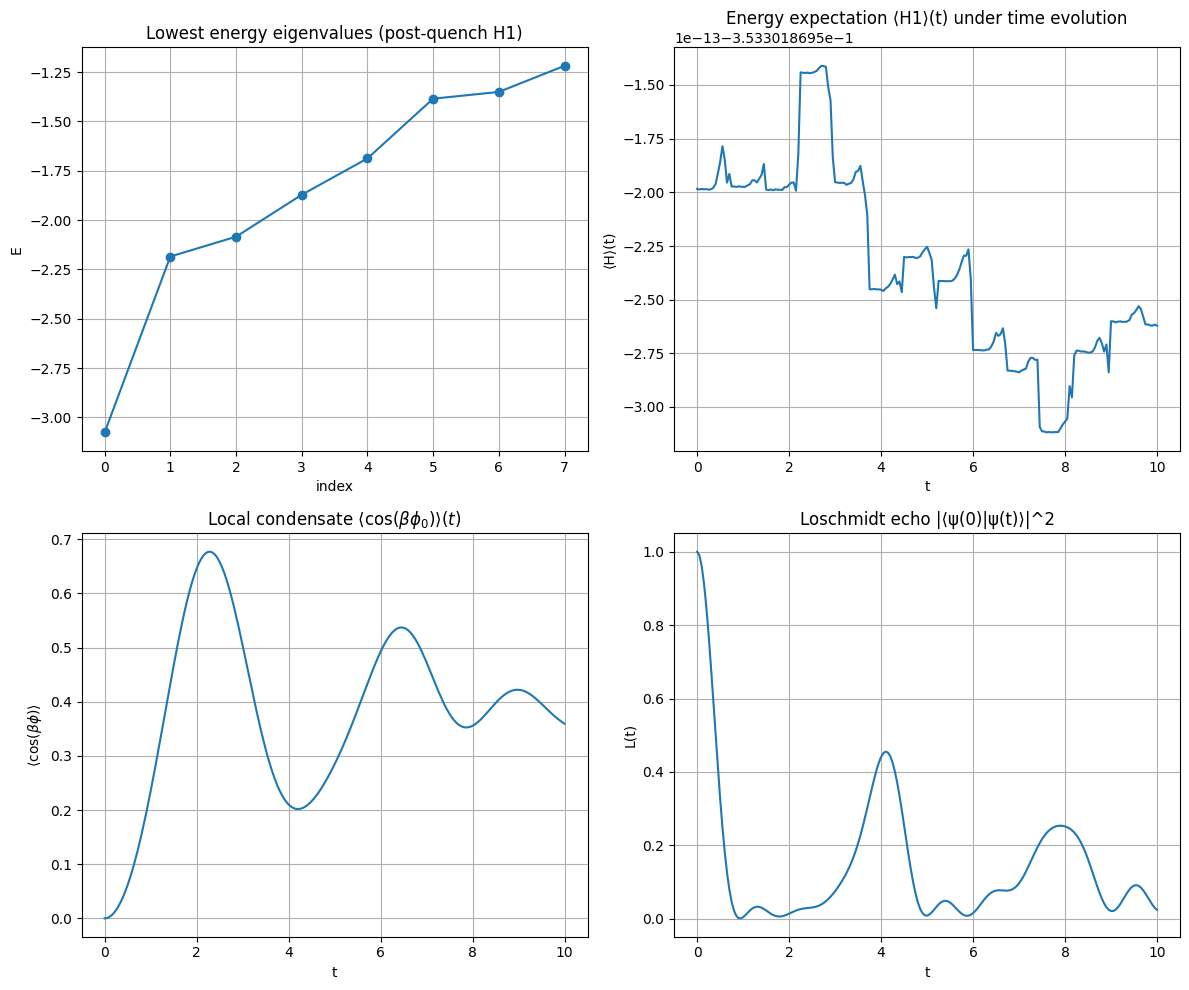


Diagnostics summary:
Initial energy ⟨H1⟩(t=0): -0.35330187
Mean energy during evolution: -0.35330187, std: 4.35e-14
Loschmidt echo at final time: 2.405557e-02


In [5]:
# Python code to build a small quantum rotor (lattice sine-Gordon) model,
# perform exact diagonalization (low-lying spectrum), do time-evolution after a quench,
# and plot: energy spectrum, time evolution of energy, local condensate <cos(phi)> and Loschmidt echo.
#
# This code runs in the notebook environment and displays plots.
# Requirements: numpy, scipy, matplotlib
#
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.sparse.linalg import eigsh, expm_multiply
import matplotlib.pyplot as plt
import math
import time
# --- Model parameters ---
N = 4                  # number of lattice sites (small for ED)
M = 3                  # truncation: local charge m in [-M..M], local dim = 2M+1
d = 2*M + 1
U = 1.0                # onsite "charging" coefficient (n^2 term prefactor)
J = 0.5                # nearest-neighbor coupling strength (hopping of phase)
g_quench = 1.0         # cosine potential strength after quench (final)
g_initial = 0.0        # initial cosine strength (prepare ground state)
beta = 1               # integer beta for exp(i beta phi) as shift^beta
tmax = 10.0
n_tsteps = 201
times = np.linspace(0.0, tmax, n_tsteps)

# --- Build single-site operators ---
# basis |m> with m = -M..M
ms = np.arange(-M, M+1)
# n operator: diagonal with m
n_local = sp.diags(ms, format='csr', dtype=complex)
# shift operator exp(i phi): shifts |m> -> |m+1>
data = []
rows = []
cols = []
for i in range(d-1):
    rows.append(i+1)  # new row index
    cols.append(i)    # old col index
    data.append(1.0)
shift = sp.csr_matrix((data, (rows, cols)), shape=(d, d), dtype=complex)
shift_dag = shift.getH()
cos_phi = 0.5 * (shift + shift_dag)   # cos(phi)
# exp(i beta phi) = shift^beta (beta integer)
shift_beta = shift.copy()
for _ in range(beta-1):
    shift_beta = shift_beta.dot(shift)
cos_beta_phi = 0.5 * (shift_beta + shift_beta.getH())

# identity local
I_local = sp.eye(d, format='csr', dtype=complex)

# --- Many-body operators via kron products ---
def kron_on_chain(local_op, site, N):
    ops = [I_local] * N
    ops[site] = local_op
    res = ops[0]
    for A in ops[1:]:
        res = sp.kron(res, A, format='csr')
    return res

def two_site_hop(op_left, op_right, site, site2, N):
    # op_left acts on site, op_right acts on site2
    ops = [I_local] * N
    ops[site] = op_left
    ops[site2] = op_right
    res = ops[0]
    for A in ops[1:]:
        res = sp.kron(res, A, format='csr')
    return res

# Precompute local many-body operators lists for efficient sum
n_ops = [kron_on_chain(n_local, i, N) for i in range(N)]
cos_ops = [kron_on_chain(cos_phi, i, N) for i in range(N)]
cos_beta_ops = [kron_on_chain(cos_beta_phi, i, N) for i in range(N)]
shift_ops = [kron_on_chain(shift, i, N) for i in range(N)]
shiftdag_ops = [kron_on_chain(shift_dag, i, N) for i in range(N)]

dim = d**N
print(f"System: N={N}, local dim={d}, total dim={dim}")

# --- Build Hamiltonian function (returns sparse H) ---
def build_sg_hamiltonian(U, J, g_cos, periodic=False):
    H = sp.csr_matrix((dim, dim), dtype=complex)
    # onsite charging term U/2 n^2
    for i in range(N):
        H += 0.5 * U * (n_ops[i].dot(n_ops[i]))
    # nearest-neighbor coupling using cos(phi_i - phi_j) ≈ (shift_i shift_j^† + h.c.)/2
    for i in range(N-1):
        H += -J * 0.5 * (shift_ops[i].dot(shiftdag_ops[i+1]) + shiftdag_ops[i].dot(shift_ops[i+1]))
    if periodic:
        H += -J * 0.5 * (shift_ops[N-1].dot(shiftdag_ops[0]) + shiftdag_ops[N-1].getH().dot(shift_ops[0]))
    # onsite cosine potential -g cos(beta phi)
    for i in range(N):
        H += - g_cos * cos_beta_ops[i]
    return H

# Build initial and final Hamiltonians
H0 = build_sg_hamiltonian(U=U, J=J, g_cos=g_initial, periodic=False)
H1 = build_sg_hamiltonian(U=U, J=J, g_cos=g_quench, periodic=False)

# --- Exact diagonalization: compute a few lowest eigenvalues and eigenvectors for H1 ---
k = 8  # number of eigenvalues
t0 = time.time()
# Use eigsh (Hermitian) to compute smallest eigenvalues
vals, vecs = eigsh(H1, k=k, which='SA', tol=1e-8, maxiter=5000)
order = np.argsort(vals.real)
vals = vals[order]
vecs = vecs[:, order]
t1 = time.time()
print("ED done: lowest eigenvalues:", vals.real)
print("ED time:", t1 - t0, "s")

# Ground state of H0 (initial state) - compute lowest eigenvector of H0
v0, vec0 = eigsh(H0, k=1, which='SA', tol=1e-8, maxiter=5000)
psi0 = vec0[:,0]
# normalize (eigsh should return normalized vector)
psi0 = psi0 / np.linalg.norm(psi0)

# --- Time evolution under H1 (post-quench) using expm_multiply
# compute psi(t) = exp(-i H1 t) psi0 at times array
print("Starting time evolution (expm_multiply)...")
tstart = time.time()
# expm_multiply accepts sparse matrix and vector and array of times multiplied by -i*H1
# We'll compute sequentially using expm_multiply with times to get psi(t) vectors.
psis_t = expm_multiply((-1j * H1), psi0, start=0.0, stop=tmax, num=n_tsteps)
tstop = time.time()
print("Time evolution done in", tstop - tstart, "s")

# --- Observables over time
energies_t = np.empty(n_tsteps, dtype=float)
local_cond_site0 = np.empty(n_tsteps, dtype=float)  # <cos(beta phi)> at site 0
loschmidt = np.empty(n_tsteps, dtype=float)

for idx in range(n_tsteps):
    psi_t = psis_t[idx]
    # energy expectation
    e = np.vdot(psi_t, H1.dot(psi_t))
    energies_t[idx] = e.real
    # local condensate: <cos(beta phi)_site0>
    c0 = np.vdot(psi_t, cos_beta_ops[0].dot(psi_t))
    local_cond_site0[idx] = c0.real
    # Loschmidt echo: |<psi0|psi(t)>|^2
    overlap = np.vdot(psi0, psi_t)
    loschmidt[idx] = np.abs(overlap)**2

# --- Plots ---
plt.rcParams.update({'figure.max_open_warning': 0})
fig = plt.figure(figsize=(12, 10))

# Panel 1: energy spectrum (lowest few eigenvalues)
ax1 = fig.add_subplot(2,2,1)
ax1.plot(np.arange(len(vals)), vals.real, marker='o')
ax1.set_title("Lowest energy eigenvalues (post-quench H1)")
ax1.set_xlabel("index"); ax1.set_ylabel("E")
ax1.grid(True)

# Panel 2: energy expectation vs time
ax2 = fig.add_subplot(2,2,2)
ax2.plot(times, energies_t)
ax2.set_title("Energy expectation ⟨H1⟩(t) under time evolution")
ax2.set_xlabel("t"); ax2.set_ylabel("⟨H⟩(t)")
ax2.grid(True)

# Panel 3: local condensate <cos(beta phi)> at site 0 vs time
ax3 = fig.add_subplot(2,2,3)
ax3.plot(times, local_cond_site0)
ax3.set_title(r"Local condensate $\langle \cos(\beta\phi_{0})\rangle(t)$")
ax3.set_xlabel("t"); ax3.set_ylabel(r"$\langle \cos(\beta\phi)\rangle$")
ax3.grid(True)

# Panel 4: Loschmidt echo
ax4 = fig.add_subplot(2,2,4)
ax4.plot(times, loschmidt)
ax4.set_title("Loschmidt echo |⟨ψ(0)|ψ(t)⟩|^2")
ax4.set_xlabel("t"); ax4.set_ylabel("L(t)")
ax4.grid(True)

plt.tight_layout()
plt.show()

# Print final diagnostics
print("\nDiagnostics summary:")
print(f"Initial energy ⟨H1⟩(t=0): {energies_t[0]:.8f}")
print(f"Mean energy during evolution: {np.mean(energies_t):.8f}, std: {np.std(energies_t):.2e}")
print(f"Loschmidt echo at final time: {loschmidt[-1]:.6e}")


